In [1]:
# I was getting a ModuleNotFoundError, and I discovered that the cwd (current working directory) was
#   '<Github Home>/market-modeling/examples/' but it needs to be '<Github Home>/market-modeling/'
# The following code will add the cwd's parent directory to the path Python uses to search for packages
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import os
from datetime import datetime

from models.gbm_models.Models import IndependentModel
from markets.Markets import BaseMarket
from assets.Assets import BaseAsset
from metrics.Metrics import VarType, TimeseriesMetric

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [3]:
DEBUG = True
DATA_DIR = '../data'
MARKET_NAME = 'popular_stocks'
TS_DIR = 'growth_timeseries'

In [4]:
asset_list = []
asset_metadata = pd.read_csv(os.path.join(DATA_DIR, MARKET_NAME, 'asset_metadata.tsv'), sep='\t')

for i, row in asset_metadata.iterrows():
  if DEBUG:
    if i == 5:
      break
  
  asset_ts = pd.read_csv(
    os.path.join(DATA_DIR, MARKET_NAME, TS_DIR, f"{row['id']}.csv"),
    parse_dates=['date'],
    dtype={'price' : np.float32}
  )
  
  asset = BaseAsset(
    row['name'],
    row['id'],
    {
      'signal': TimeseriesMetric(asset_ts['date'], asset_ts['price'], VarType.QUANTITATIVE)
    }
  )
  asset_list.append(asset)
  
market = BaseMarket(asset_list, MARKET_NAME)
indep_model = IndependentModel(market)

In [5]:
market.align_timeseries()
indep_model.estimate_parameters()

In [6]:
df_results = pd.DataFrame({
  'id' : [asset.asset_id for asset in indep_model.market.assets],
  'drifts' : indep_model.drifts,
  'vols' : indep_model.vols
})

df_results

,id,drifts,vols
0,AMZN,0.000702,0.000405
1,AXP,0.000774,0.000412
2,AMGN,0.000353,0.000222
3,AAPL,0.001024,0.000313
4,BA,0.000088,0.000745


In [7]:
dates_to_sim = pd.to_datetime(
  pd.Series(['12-16-2024', '12-18-2024', '12-20-2024', '12-23-2024'], name='dates'),
  format='%m-%d-%Y'
)

prev_times, prev_states = market.get_market_state_before_date(min(dates_to_sim))
assert len(set(prev_times)) == 1, "market's times misaligned"
prev_signals = [s['signal'] for s in prev_states]

sim_dates = pd.concat((pd.Series(prev_times[0:1], name='dates'), dates_to_sim))

In [8]:
sim_res = indep_model.simulate(prev_signals, sim_dates, num_sims=20)
sim_counterfact = indep_model.simulate(prev_signals, sim_dates, 1, add_BM=False)

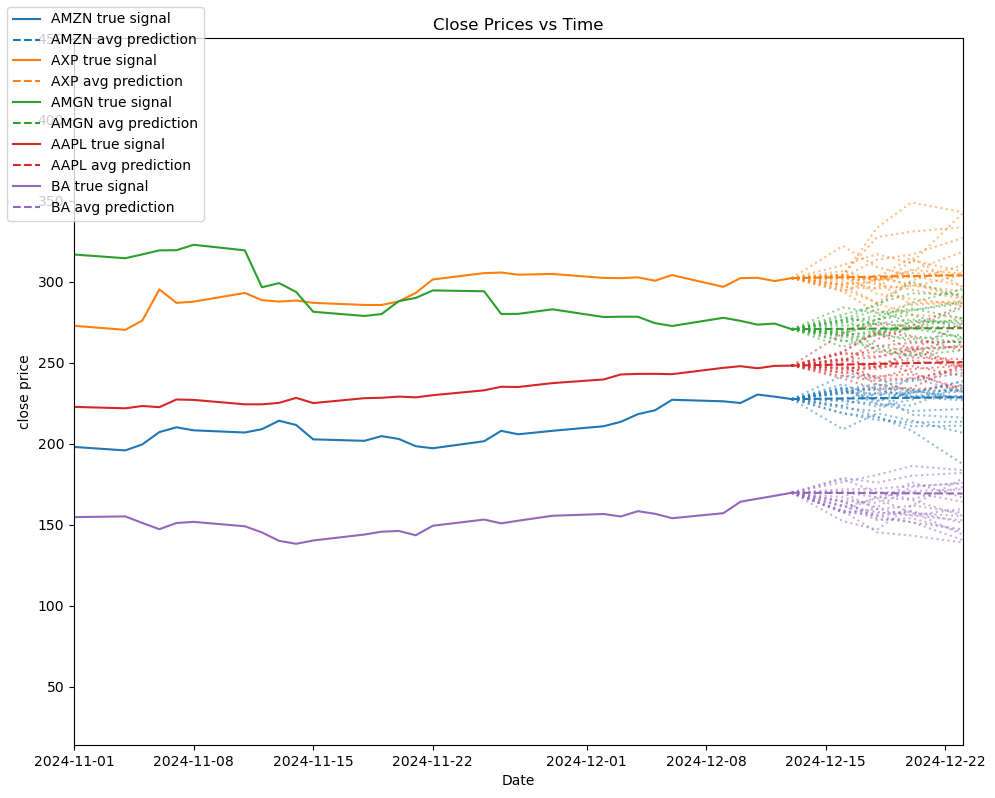

In [9]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
fig, ax = plt.subplots(figsize=(10,8))

for i in range(len(colors)): #range(indep_model.N_ASSETS):
  asset_i = indep_model.market.assets[i % indep_model.N_ASSETS]
  disp_name = asset_i.asset_id
  ax.plot(asset_i.ts_df['time'], asset_i.ts_df['signal'], label=f'{disp_name} true signal',
           color=colors[i % indep_model.N_ASSETS])

  ax.set_xlim([datetime(2024, 11, 1), sim_dates.max()])
  ax.plot(sim_dates, sim_counterfact[0, i, :], label=f'{disp_name} avg prediction',
           color=colors[i % indep_model.N_ASSETS], linestyle='dashed')
  for j_sim in range(sim_res.shape[0]):
    ax.plot(sim_dates, sim_res[j_sim, i, :],
            alpha=0.5, color=colors[i % indep_model.N_ASSETS], linestyle='dotted')
ax.set(xlabel='Date', ylabel='close price', title='Close Prices vs Time')
fig.tight_layout()
fig.legend(loc=2);